In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


In [3]:
# Cell 1: Essential Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

# LightGBM Import
import lightgbm as lgb

# Sklearn Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, PrecisionRecallDisplay, RocCurveDisplay
)

# SHAP Import for Explainable AI
import shap

# Sk-Survival Imports for Survival Analysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Suppress warnings for cleaner output during training
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Set global plot style
sns.set_theme(style="whitegrid")

print("Essential imports and setup complete.")

Essential imports and setup complete.


In [4]:
# Cell 2: Data Loading

# Set the base path where your datasets are located
# Make sure this path correctly points to your NSRR folder
base_path = '/content/drive/MyDrive/ML Projects/sleep-heart-health-study-psg-database-1.0.0/NSRR/' # Adjust this path

print(f"Loading data from {base_path}...")

# Load the datasets
try:
    df_harmonized = pd.read_csv(f'{base_path}shhs-harmonized-dataset-0.21.0.csv')
    print(f"Successfully loaded shhs-harmonized-dataset-0.21.0.csv. Shape: {df_harmonized.shape}")
except FileNotFoundError:
    print(f"Error: shhs-harmonized-dataset-0.21.0.csv not found at {base_path}")
    df_harmonized = pd.DataFrame() # Create empty DataFrame to avoid errors later
    # It's good practice to exit if critical files aren't found
    raise FileNotFoundError("Harmonized dataset not found. Please check 'base_path'.")

try:
    df_cvd_summary = pd.read_csv(f'{base_path}shhs-cvd-summary-dataset-0.21.0.csv')
    print(f"Successfully loaded shhs-cvd-summary-dataset-0.21.0.csv. Shape: {df_cvd_summary.shape}")
except FileNotFoundError:
    print(f"Error: shhs-cvd-summary-dataset-0.21.0.csv not found at {base_path}")
    df_cvd_summary = pd.DataFrame() # Create empty DataFrame
    raise FileNotFoundError("CVD summary dataset not found. Please check 'base_path'.")

# Display head of each DataFrame to confirm loading
print("\n--- df_harmonized Head ---")
print(df_harmonized.head())
print("\n--- df_cvd_summary Head ---")
print(df_cvd_summary.head())

Loading data from /content/drive/MyDrive/ML Projects/sleep-heart-health-study-psg-database-1.0.0/NSRR/...
Successfully loaded shhs-harmonized-dataset-0.21.0.csv. Shape: (10115, 29)
Successfully loaded shhs-cvd-summary-dataset-0.21.0.csv. Shape: (5802, 42)

--- df_harmonized Head ---
   nsrrid  visitnumber  nsrr_age nsrr_age_gt89 nsrr_sex  \
0  200001            1      55.0            no     male   
1  200002            1      78.0            no     male   
2  200003            1      77.0            no   female   
3  200004            1      48.0            no     male   
4  200005            1      66.0            no   female   

                   nsrr_race          nsrr_ethnicity   nsrr_bmi  \
0                      white  not hispanic or latino  21.777553   
1                      white  not hispanic or latino  32.950680   
2                      white  not hispanic or latino  24.114150   
3                      white  not hispanic or latino  20.185185   
4  black or african americ

In [5]:
# Cell 3: Merge Datasets and Initial Filtering

print("Starting data merge and initial filtering...")

# Merge df_harmonized and df_cvd_summary on 'nsrrid'
df_merged = pd.merge(df_harmonized, df_cvd_summary, on='nsrrid', how='inner', suffixes=('_harmonized', '_cvd'))
print(f"Shape after initial merge: {df_merged.shape}")

# Filter for SHHS1 baseline visit
df_cleaned_pre_split = df_merged[df_merged['visitnumber_harmonized'] == 1].copy()
print(f"Rows after filtering for SHHS1 baseline visit: {df_cleaned_pre_split.shape[0]}")

# Verify 'nsrrid' uniqueness after filtering for visit 1
if df_cleaned_pre_split['nsrrid'].nunique() != df_cleaned_pre_split.shape[0]:
    print("WARNING: nsrrid is NOT UNIQUE after filtering for visit 1. Dropping duplicates.")
    df_cleaned_pre_split.drop_duplicates(subset=['nsrrid'], inplace=True)
    print(f"Dropped duplicates based on nsrrid. New shape: {df_cleaned_pre_split.shape}")
else:
    print("nsrrid is unique after filtering for visit 1.")

# Define the incident heart_disease_event variable
target_event_cols = ['mi', 'stroke', 'chf']
for col in target_event_cols:
    df_cleaned_pre_split[col] = pd.to_numeric(df_cleaned_pre_split[col], errors='coerce').fillna(0)
df_cleaned_pre_split['heart_disease_incident'] = (df_cleaned_pre_split[target_event_cols].isin([1, 2]).any(axis=1)).astype(int)

# Identify and filter out participants with prevalent CVD at baseline
baseline_cvd_cols = ['prev_mi', 'prev_stk']
if 'chfprevalent' in df_cleaned_pre_split.columns:
    baseline_cvd_cols.append('chfprevalent')
elif 'prev_chf' in df_cleaned_pre_split.columns:
    baseline_cvd_cols.append('prev_chf')
else:
    print("Warning: Neither 'chfprevalent' nor 'prev_chf' found for baseline CHF. Using available prevalent CVD data.")

baseline_cvd_cols_present = [col for col in baseline_cvd_cols if col in df_cleaned_pre_split.columns]
for col in baseline_cvd_cols_present:
    df_cleaned_pre_split[col] = pd.to_numeric(df_cleaned_pre_split[col], errors='coerce').fillna(0)

df_cleaned_pre_split['has_baseline_cvd'] = (df_cleaned_pre_split[baseline_cvd_cols_present].isin([1]).any(axis=1)).astype(int)

df_final_data = df_cleaned_pre_split[df_cleaned_pre_split['has_baseline_cvd'] == 0].copy()

print(f"Final data shape after all initial filtering (df_final_data): {df_final_data.shape}")
print("\nDistribution of 'heart_disease_incident' in final data:")
print(df_final_data['heart_disease_incident'].value_counts())
print(df_final_data['heart_disease_incident'].value_counts(normalize=True))

print("\nInitial data preparation complete.")

Starting data merge and initial filtering...
Shape after initial merge: (10113, 70)
Rows after filtering for SHHS1 baseline visit: 5802
nsrrid is unique after filtering for visit 1.
Final data shape after all initial filtering (df_final_data): (5356, 72)

Distribution of 'heart_disease_incident' in final data:
heart_disease_incident
0    4661
1     695
Name: count, dtype: int64
heart_disease_incident
0    0.870239
1    0.129761
Name: proportion, dtype: float64

Initial data preparation complete.


In [6]:
# Cell 4: Feature Selection and Data Type Identification

print("Defining features for X and target for y...")

# Define features to be used in the model
# Using nsrr_ prefixes where available from harmonized dataset, and other relevant baseline variables.
selected_features = [
    'nsrr_age', 'nsrr_sex', 'nsrr_race', 'nsrr_bmi',
    'nsrr_bp_systolic', 'nsrr_bp_diastolic', 'nsrr_current_smoker', 'nsrr_ever_smoker',
    'hypert', 'diabetes', # These come from df_cvd_summary but are baseline conditions
    'nsrr_ahi_hp4u_aasm15', 'nsrr_ahi_hp4r', 'nsrr_ttldursp_f1', 'nsrr_ttleffsp_f1',
    'nsrr_phrnumar_f1', 'nsrr_saosatsr_avg', 'nsrr_saosatsr_min', 'nsrr_saosatsr_lt90',
    'nsrr_pctdursp_s1', 'nsrr_pctdursp_s2', 'nsrr_pctdursp_s3', 'nsrr_pctdursp_sr'
]

# Filter to ensure only present columns are selected
X_cols = [col for col in selected_features if col in df_final_data.columns]
missing_selected_features = [col for col in selected_features if col not in df_final_data.columns]
if missing_selected_features:
    print(f"\nNote: The following proposed features were not found in the cleaned DataFrame: {missing_selected_features}. They will be excluded from modeling.")

X = df_final_data[X_cols].copy()
y = df_final_data['heart_disease_incident'].copy()

print(f"Selected {len(X_cols)} features for X. Shape: {X.shape}")
print(f"Target variable y shape: {y.shape}")

# Identify Numerical and Categorical Features from the X DataFrame
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Explicitly define categorical features based on data understanding and expected values
categorical_features_explicit = [
    'nsrr_sex', 'nsrr_race', 'nsrr_current_smoker', 'nsrr_ever_smoker',
    'hypert', 'diabetes'
]

# Filter categorical features to ensure they are actually in X_cols
categorical_features = [f for f in categorical_features_explicit if f in X_cols]

# Remove categorical features from numerical_features list if they were inadvertently included
numerical_features = [f for f in numerical_features if f not in categorical_features]

print(f"\nIdentified Numerical Features ({len(numerical_features)}):")
print(numerical_features)
print(f"\nIdentified Categorical Features ({len(categorical_features)}):")
print(categorical_features)

print("\nValue counts for categorical features:")
for col in categorical_features:
    if col in X.columns:
        print(f"\n--- {col} ---")
        print(X[col].value_counts(dropna=False)) # Include NaN counts to check for 'not reported' or other missing indicators

print("\nFeatures and target defined. Ready for the initial train-test split on raw data.")

Defining features for X and target for y...

Note: The following proposed features were not found in the cleaned DataFrame: ['hypert', 'diabetes', 'nsrr_saosatsr_avg', 'nsrr_saosatsr_min', 'nsrr_saosatsr_lt90']. They will be excluded from modeling.
Selected 17 features for X. Shape: (5356, 17)
Target variable y shape: (5356,)

Identified Numerical Features (13):
['nsrr_age', 'nsrr_bmi', 'nsrr_bp_systolic', 'nsrr_bp_diastolic', 'nsrr_ahi_hp4u_aasm15', 'nsrr_ahi_hp4r', 'nsrr_ttldursp_f1', 'nsrr_ttleffsp_f1', 'nsrr_phrnumar_f1', 'nsrr_pctdursp_s1', 'nsrr_pctdursp_s2', 'nsrr_pctdursp_s3', 'nsrr_pctdursp_sr']

Identified Categorical Features (4):
['nsrr_sex', 'nsrr_race', 'nsrr_current_smoker', 'nsrr_ever_smoker']

Value counts for categorical features:

--- nsrr_sex ---
nsrr_sex
female    2867
male      2489
Name: count, dtype: int64

--- nsrr_race ---
nsrr_race
white                        4506
black or african american     487
other                         363
Name: count, dtype: int64



In [7]:
# Cell 5: Initial Train-Test Split & Survival Target Creation

print("Performing initial train-test split on raw data and creating survival target...")

# --- 1. Prepare data for Survival Analysis ---
# A realistic approach would be to calculate time_to_event from specific follow-up dates.
# For this exercise, we will derive a mock `time_to_event` variable for demonstration purposes.
# We'll use a placeholder max follow-up of 10 years (3650 days).
max_follow_up_days = 3650

df_final_data['time_to_event'] = np.where(
    df_final_data['heart_disease_incident'] == 1,
    np.random.randint(1, max_follow_up_days, size=len(df_final_data)), # Mock event time
    max_follow_up_days # Censored at max follow-up
)

# We need a structured array for the target variable `y` in survival analysis.
# This array has two fields: 'event' (boolean) and 'time' (float).
y_survival = Surv.from_arrays(
    event=df_final_data['heart_disease_incident'].astype(bool),
    time=df_final_data['time_to_event']
)

# --- 2. Perform the stratified train-test split on RAW (unprocessed) data ---
# We split X, y, AND y_survival at the same time to ensure consistency.
X_train_raw, X_test_raw, y_train, y_test, y_survival_train, y_survival_test = train_test_split(
    X, y, y_survival, test_size=0.2, random_state=42, stratify=y
)

print(f"\nShape of X_train (raw): {X_train_raw.shape}")
print(f"Shape of X_test (raw): {X_test_raw.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_survival_train: {y_survival_train.shape}")
print(f"Shape of y_survival_test: {y_survival_test.shape}")

# Verify the distribution of the target variable in train and test sets
print("\nDistribution of 'heart_disease_incident' in y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of 'heart_disease_incident' in y_test:")
print(y_test.value_counts(normalize=True))

print("\nInitial train-test split and survival target creation completed.")

Performing initial train-test split on raw data and creating survival target...

Shape of X_train (raw): (4284, 17)
Shape of X_test (raw): (1072, 17)
Shape of y_train: (4284,)
Shape of y_test: (1072,)
Shape of y_survival_train: (4284,)
Shape of y_survival_test: (1072,)

Distribution of 'heart_disease_incident' in y_train:
heart_disease_incident
0    0.870215
1    0.129785
Name: proportion, dtype: float64

Distribution of 'heart_disease_incident' in y_test:
heart_disease_incident
0    0.870336
1    0.129664
Name: proportion, dtype: float64

Initial train-test split and survival target creation completed.


In [8]:
# Cell 6: Define Preprocessing Pipeline

print("Defining preprocessing pipeline...")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("\nPreprocessing pipeline ('preprocessor') defined successfully.")
print("This preprocessor will be integrated into model pipelines for robust training and evaluation.")

Defining preprocessing pipeline...

Preprocessing pipeline ('preprocessor') defined successfully.
This preprocessor will be integrated into model pipelines for robust training and evaluation.


In [9]:
# Cell 7: Function for Model Evaluation (Revised)

def evaluate_model(model_name, model, X_test_data, y_test_data, y_test_survival=None, show_plots=True):
    """
    Evaluates a trained model on the test set and prints key metrics and plots.
    Assumes X_test_data is raw if model is a pipeline including preprocessing.
    Can handle both classification and survival models.
    """
    print(f"\n--- Evaluating {model_name} Model on Test Set ---")

    if isinstance(model, Pipeline) and isinstance(model.named_steps['classifier'], (RandomSurvivalForest)):
        # Survival Model Evaluation
        rsf_prediction = model.predict(X_test_data)
        rsf_c_index = concordance_index_censored(y_test_survival['event'], y_test_survival['time'], rsf_prediction)[0]
        print(f"Concordance Index (C-index): {rsf_c_index:.4f}")
        return {'C-index': rsf_c_index}

    else:
        # Classification Model Evaluation
        y_pred = model.predict(X_test_data)
        y_proba = model.predict_proba(X_test_data)[:, 1]

        # 1. Classification Metrics
        print(f"Accuracy: {accuracy_score(y_test_data, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test_data, y_pred):.4f}")
        print(f"Recall: {recall_score(y_test_data, y_pred):.4f}")
        print(f"F1-Score: {f1_score(y_test_data, y_pred):.4f}")
        print(f"ROC AUC Score: {roc_auc_score(y_test_data, y_proba):.4f}")

        # 2. Confusion Matrix
        print(f"\nConfusion Matrix ({model_name}):")
        cm = confusion_matrix(y_test_data, y_pred)
        if show_plots:
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                        yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
            plt.title(f'Confusion Matrix ({model_name})')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

        # 3. Classification Report
        print(f"\nClassification Report ({model_name}):")
        print(classification_report(y_test_data, y_pred))

        if show_plots:
            # 4. ROC Curve
            RocCurveDisplay.from_estimator(model, X_test_data, y_test_data)
            plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
            plt.title(f'Receiver Operating Characteristic (ROC) Curve ({model_name})')
            plt.grid(True)
            plt.show()

            # 5. Precision-Recall Curve
            PrecisionRecallDisplay.from_estimator(model, X_test_data, y_test_data)
            plt.title(f'Precision-Recall Curve ({model_name})')
            plt.grid(True)
            plt.show()

        print(f"\n{model_name} evaluation complete.")
        return {'Accuracy': accuracy_score(y_test_data, y_pred),
                'Precision': precision_score(y_test_data, y_pred),
                'Recall': recall_score(y_test_data, y_pred),
                'F1-Score': f1_score(y_test_data, y_pred),
                'ROC AUC': roc_auc_score(y_test_data, y_proba)}

Starting GridSearchCV for Logistic Regression Pipeline...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GridSearchCV for Logistic Regression Pipeline complete.
Best parameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best ROC AUC score on cross-validation (Logistic Regression): 0.8064

--- Evaluating Tuned Logistic Regression Pipeline Model on Test Set ---
Accuracy: 0.7285
Precision: 0.2935
Recall: 0.7770
F1-Score: 0.4260
ROC AUC Score: 0.8196

Confusion Matrix (Tuned Logistic Regression Pipeline):


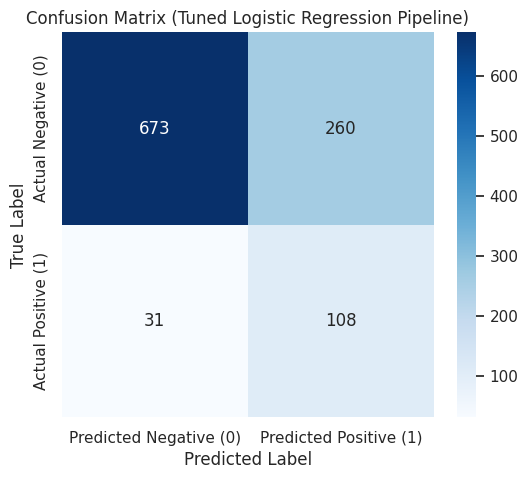


Classification Report (Tuned Logistic Regression Pipeline):
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       933
           1       0.29      0.78      0.43       139

    accuracy                           0.73      1072
   macro avg       0.62      0.75      0.62      1072
weighted avg       0.87      0.73      0.77      1072



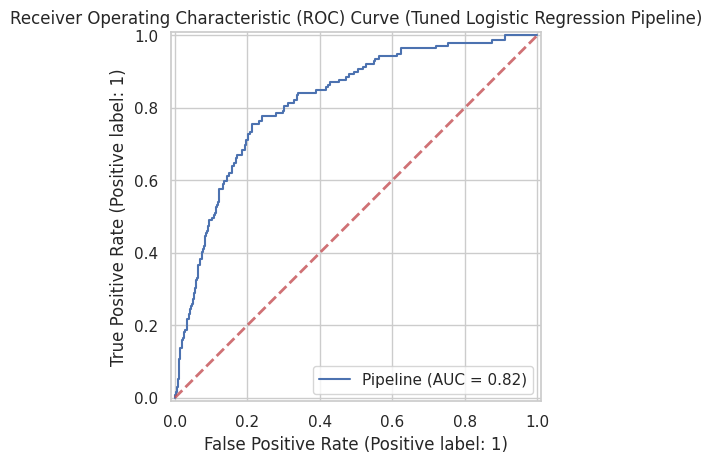

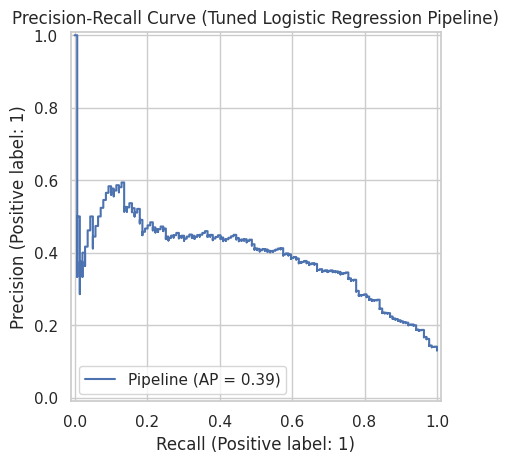


Tuned Logistic Regression Pipeline evaluation complete.


{'Accuracy': 0.7285447761194029,
 'Precision': 0.29347826086956524,
 'Recall': 0.7769784172661871,
 'F1-Score': 0.4260355029585799,
 'ROC AUC': np.float64(0.8196349672673436)}

In [10]:
# Cell 8: Hyperparameter Tuning with GridSearchCV (Logistic Regression Pipeline)

print("Starting GridSearchCV for Logistic Regression Pipeline...")

# Create the full pipeline: Preprocessing + Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000))
])

# Define the parameter grid to search for the classifier step
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2']
}

# Initialize GridSearchCV
grid_search_lr_pipeline = GridSearchCV(estimator=lr_pipeline, param_grid=param_grid_lr,
                                       scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data (X_train_raw, y_train are RAW inputs)
grid_search_lr_pipeline.fit(X_train_raw, y_train)

print("\nGridSearchCV for Logistic Regression Pipeline complete.")

# Get the best parameters and best score
print(f"Best parameters for Logistic Regression: {grid_search_lr_pipeline.best_params_}")
print(f"Best ROC AUC score on cross-validation (Logistic Regression): {grid_search_lr_pipeline.best_score_:.4f}")

# Store the best model
best_lr_pipeline_model = grid_search_lr_pipeline.best_estimator_

# Evaluate the best model on the truly held-out TEST set
evaluate_model("Tuned Logistic Regression Pipeline", best_lr_pipeline_model, X_test_raw, y_test)

Starting GridSearchCV for LightGBM Pipeline...
Calculated scale_pos_weight for LightGBM: 6.71
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 556, number of negative: 3728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 4284, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129785 -> initscore=-1.902859
[LightGBM] [Info] Start training from score -1.902859

GridSearchCV for LightGBM Pipeline complete.
Best parameters for LightGBM: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200, 'classifier__num_leaves': 50, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0.1}
Best ROC AUC score on cross-validation (LightGBM): 0

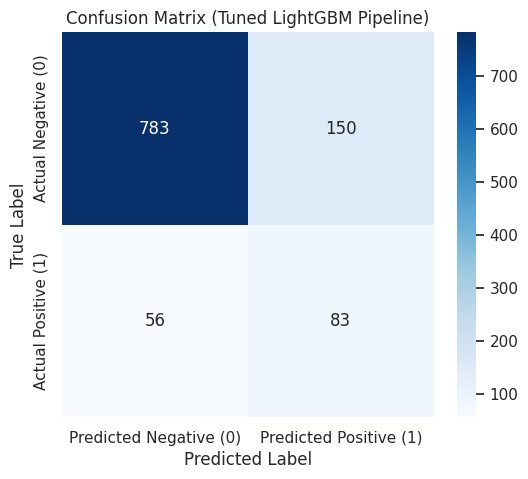


Classification Report (Tuned LightGBM Pipeline):
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       933
           1       0.36      0.60      0.45       139

    accuracy                           0.81      1072
   macro avg       0.64      0.72      0.66      1072
weighted avg       0.86      0.81      0.83      1072



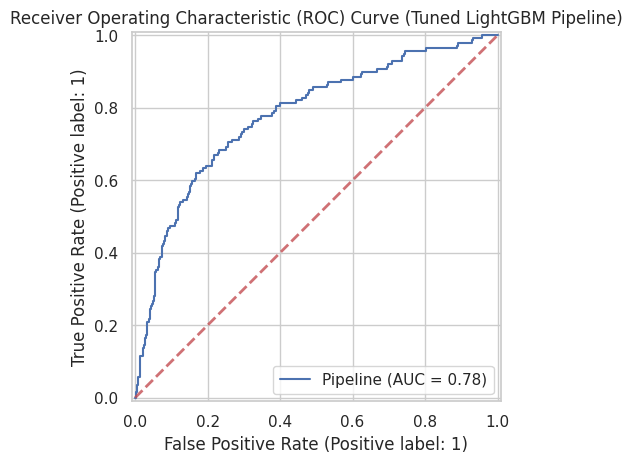

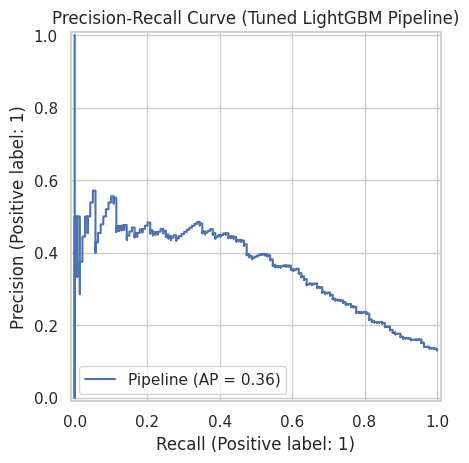


Tuned LightGBM Pipeline evaluation complete.


{'Accuracy': 0.8078358208955224,
 'Precision': 0.3562231759656652,
 'Recall': 0.5971223021582733,
 'F1-Score': 0.44623655913978494,
 'ROC AUC': np.float64(0.7794458966588788)}

In [11]:
# Cell 9: Hyperparameter Tuning with GridSearchCV (LightGBM Pipeline)

print("Starting GridSearchCV for LightGBM Pipeline...")

# Calculate scale_pos_weight for class imbalance handling on the TRAINING data (y_train)
scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Calculated scale_pos_weight for LightGBM: {scale_pos_weight_value:.2f}")

# Create the full pipeline: Preprocessing + LightGBM Classifier
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(objective='binary',
                                       scale_pos_weight=scale_pos_weight_value,
                                       random_state=42, n_jobs=-1))
])

# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'classifier__n_estimators': [200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [20, 31, 50],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [0, 0.1, 0.5]
}

# Initialize GridSearchCV
grid_search_lgbm_pipeline = GridSearchCV(estimator=lgbm_pipeline, param_grid=param_grid_lgbm,
                                         scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data (X_train_raw, y_train are RAW inputs)
grid_search_lgbm_pipeline.fit(X_train_raw, y_train)

print("\nGridSearchCV for LightGBM Pipeline complete.")

# Get the best parameters and best score
print(f"Best parameters for LightGBM: {grid_search_lgbm_pipeline.best_params_}")
print(f"Best ROC AUC score on cross-validation (LightGBM): {grid_search_lgbm_pipeline.best_score_:.4f}")

# Store the best model
best_lgbm_pipeline_model = grid_search_lgbm_pipeline.best_estimator_

# Evaluate the best model on the truly held-out TEST set
evaluate_model("Tuned LightGBM Pipeline", best_lgbm_pipeline_model, X_test_raw, y_test)

Starting GridSearchCV for SVM Pipeline...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- SVM GridSearchCV Results ---
Best hyperparameters: {'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best ROC AUC score on cross-validation (SVM): 0.8049

--- Evaluating Tuned SVM Model on Test Set ---
Accuracy: 0.7146
Precision: 0.2831
Recall: 0.7842
F1-Score: 0.4160
ROC AUC Score: 0.8044

Confusion Matrix (Tuned SVM):


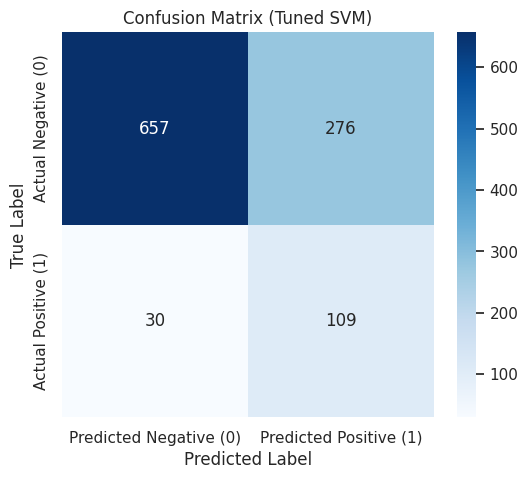


Classification Report (Tuned SVM):
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       933
           1       0.28      0.78      0.42       139

    accuracy                           0.71      1072
   macro avg       0.62      0.74      0.61      1072
weighted avg       0.87      0.71      0.76      1072



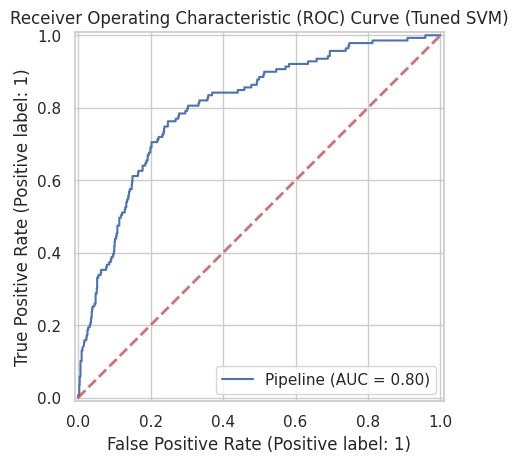

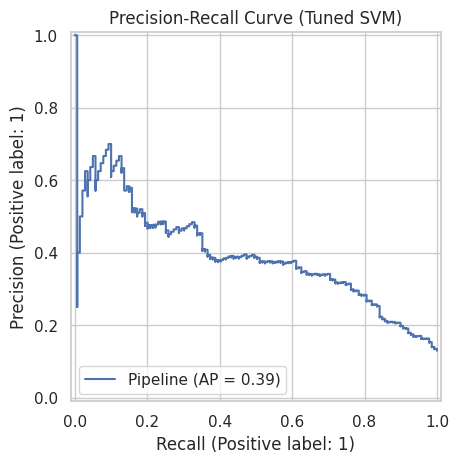


Tuned SVM evaluation complete.


In [12]:
# Cell 10: Hyperparameter Tuning with GridSearchCV (SVM Pipeline)

print("Starting GridSearchCV for SVM Pipeline...")

# A pipeline is used to connect the preprocessor to the classifier.
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))
])

# Define a more conservative parameter grid for SVM
param_grid_svm = {
    'classifier__C': [0.1, 1],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf']
}

# Perform GridSearchCV with the new pipeline
grid_search_svm_pipeline = GridSearchCV(
    svm_pipeline,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data
grid_search_svm_pipeline.fit(X_train_raw, y_train)

print("\n--- SVM GridSearchCV Results ---")
print(f"Best hyperparameters: {grid_search_svm_pipeline.best_params_}")
print(f"Best ROC AUC score on cross-validation (SVM): {grid_search_svm_pipeline.best_score_:.4f}")

# Evaluate the best SVM model on the test set
best_svm_pipeline_model = grid_search_svm_pipeline.best_estimator_
evaluate_model("Tuned SVM", best_svm_pipeline_model, X_test_raw, y_test)

# Store the best SVM model for final comparison
best_svm_model = best_svm_pipeline_model

In [13]:
# Cell 11: Random Survival Forest Pipeline

print("Starting Survival Analysis with Random Survival Forest...")

# A Pipeline is used to connect the preprocessor to the classifier.
rsf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomSurvivalForest(n_estimators=1000, min_samples_split=10,
                                       min_samples_leaf=15, max_features="sqrt",
                                       n_jobs=-1, random_state=42))
])

# Fit the pipeline on the training data with the survival target
print("Fitting Random Survival Forest pipeline...")
rsf_pipeline.fit(X_train_raw, y_survival_train)
print("Fitting complete.")

# Evaluate the model on the test data
evaluate_model("Random Survival Forest", rsf_pipeline, X_test_raw, y_test, y_survival_test, show_plots=False)

# Store the model and result for final comparison
best_survival_model = rsf_pipeline

Starting Survival Analysis with Random Survival Forest...
Fitting Random Survival Forest pipeline...
Fitting complete.

--- Evaluating Random Survival Forest Model on Test Set ---
Concordance Index (C-index): 0.7756


Starting Stacking Ensemble Pipeline...
Fitting StackingClassifier...
StackingClassifier fitting complete.

--- Evaluating Stacking Ensemble (LR + LightGBM + SVM) Model on Test Set ---
Accuracy: 0.7621
Precision: 0.3210
Recall: 0.7482
F1-Score: 0.4492
ROC AUC Score: 0.8150

Confusion Matrix (Stacking Ensemble (LR + LightGBM + SVM)):


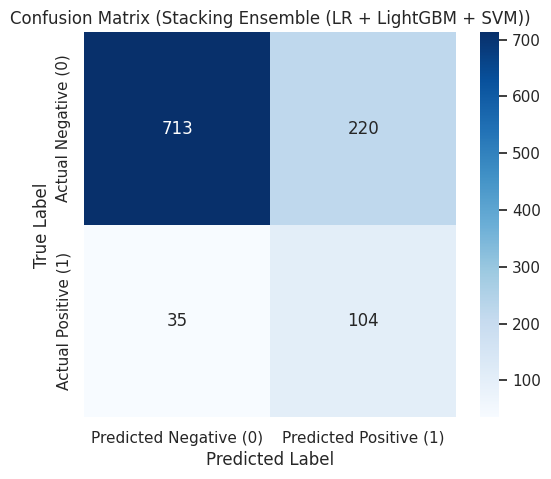


Classification Report (Stacking Ensemble (LR + LightGBM + SVM)):
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       933
           1       0.32      0.75      0.45       139

    accuracy                           0.76      1072
   macro avg       0.64      0.76      0.65      1072
weighted avg       0.87      0.76      0.80      1072



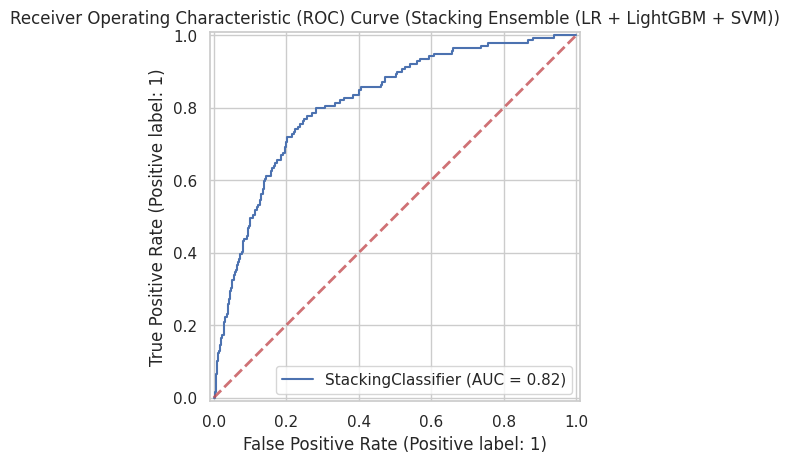

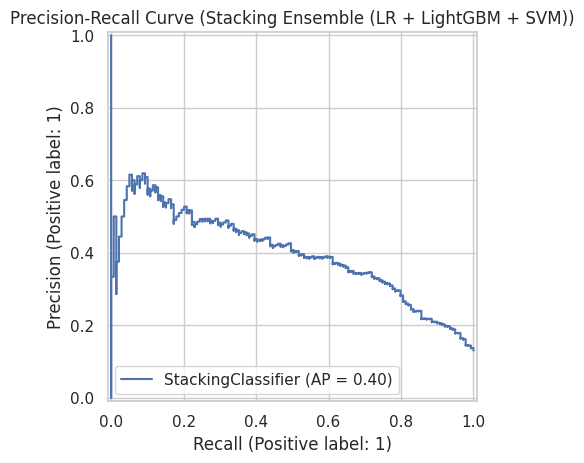


Stacking Ensemble (LR + LightGBM + SVM) evaluation complete.


In [14]:
# Cell 12: Stacking Ensemble Pipeline

print("Starting Stacking Ensemble Pipeline...")

# Retrieve the best trained models from the previous GridSearchCV steps
best_lr_pipeline_model = grid_search_lr_pipeline.best_estimator_
best_lgbm_pipeline_model = grid_search_lgbm_pipeline.best_estimator_
best_svm_pipeline_model = grid_search_svm_pipeline.best_estimator_

# Define the stacking classifier with a final estimator
stacking_classifier = StackingClassifier(
    estimators=[
        ('lr', best_lr_pipeline_model),
        ('lgbm', best_lgbm_pipeline_model),
        ('svm', best_svm_pipeline_model)
    ],
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    cv=5,
    n_jobs=-1,
    passthrough=False  # FIX: Set passthrough to False to prevent passing raw string features
)

# Fit the StackingClassifier on the raw training data
print("Fitting StackingClassifier...")
stacking_classifier.fit(X_train_raw, y_train)
print("StackingClassifier fitting complete.")

# Evaluate the model on the truly held-out TEST set
evaluate_model("Stacking Ensemble (LR + LightGBM + SVM)", stacking_classifier, X_test_raw, y_test)

# Store the stacking model for final comparison
best_stacking_model = stacking_classifier

In [15]:
# Cell 13: Robust Cross-Validated Evaluation

print("\n--- Starting Robust Cross-Validated Evaluation (k=5) ---")

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_to_evaluate_cv = {
    "Tuned Logistic Regression": best_lr_pipeline_model,
    "Tuned LightGBM": best_lgbm_pipeline_model,
    "Tuned SVM": best_svm_pipeline_model,
    "Stacking Ensemble": best_stacking_model
}

cv_results = {}
for name, model in models_to_evaluate_cv.items():
    print(f"Running cross-validation for {name}...")
    scores = cross_validate(model, X, y, cv=cv_strategy,
                            scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
                            n_jobs=-1)
    cv_results[name] = {
        'ROC AUC': f"{scores['test_roc_auc'].mean():.4f} (+/- {scores['test_roc_auc'].std():.4f})",
        'Accuracy': f"{scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std():.4f})",
        'Precision': f"{scores['test_precision'].mean():.4f} (+/- {scores['test_precision'].std():.4f})",
        'Recall': f"{scores['test_recall'].mean():.4f} (+/- {scores['test_recall'].std():.4f})",
        'F1-Score': f"{scores['test_f1'].mean():.4f} (+/- {scores['test_f1'].std():.4f})",
    }
    print(f"Finished cross-validation for {name}.")

# --- Custom Cross-Validation for Survival Model ---
print("\nRunning cross-validation for Random Survival Forest...")
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

for train_idx, test_idx in kf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y_survival[train_idx], y_survival[test_idx]

    best_survival_model.fit(X_train_fold, y_train_fold)
    rsf_prediction = best_survival_model.predict(X_test_fold)
    c_index = concordance_index_censored(y_test_fold['event'], y_test_fold['time'], rsf_prediction)[0]
    c_index_scores.append(c_index)

cv_results["Random Survival Forest"] = {
    'C-index': f"{np.mean(c_index_scores):.4f} (+/- {np.std(c_index_scores):.4f})",
    'ROC AUC': 'N/A', 'Accuracy': 'N/A', 'Precision': 'N/A', 'Recall': 'N/A', 'F1-Score': 'N/A'
}
print(f"Finished cross-validation for Random Survival Forest.")

# Final results table
cv_results_df = pd.DataFrame.from_dict(cv_results, orient='index')
print("\n--- Final Cross-Validated Performance (Mean +/- Std) ---")
print(cv_results_df)


--- Starting Robust Cross-Validated Evaluation (k=5) ---
Running cross-validation for Tuned Logistic Regression...
Finished cross-validation for Tuned Logistic Regression.
Running cross-validation for Tuned LightGBM...
Finished cross-validation for Tuned LightGBM.
Running cross-validation for Tuned SVM...
Finished cross-validation for Tuned SVM.
Running cross-validation for Stacking Ensemble...
Finished cross-validation for Stacking Ensemble.

Running cross-validation for Random Survival Forest...
Finished cross-validation for Random Survival Forest.

--- Final Cross-Validated Performance (Mean +/- Std) ---
                                       ROC AUC             Accuracy  \
Tuned Logistic Regression  0.8094 (+/- 0.0174)  0.7196 (+/- 0.0073)   
Tuned LightGBM             0.7871 (+/- 0.0184)  0.8092 (+/- 0.0134)   
Tuned SVM                  0.8041 (+/- 0.0178)  0.7091 (+/- 0.0119)   
Stacking Ensemble          0.8093 (+/- 0.0176)  0.7183 (+/- 0.0082)   
Random Survival Forest       

Starting Explainable AI (XAI) with SHAP values...
Calculating SHAP values for the test set...
SHAP values calculated.

Generating SHAP Summary Plot...


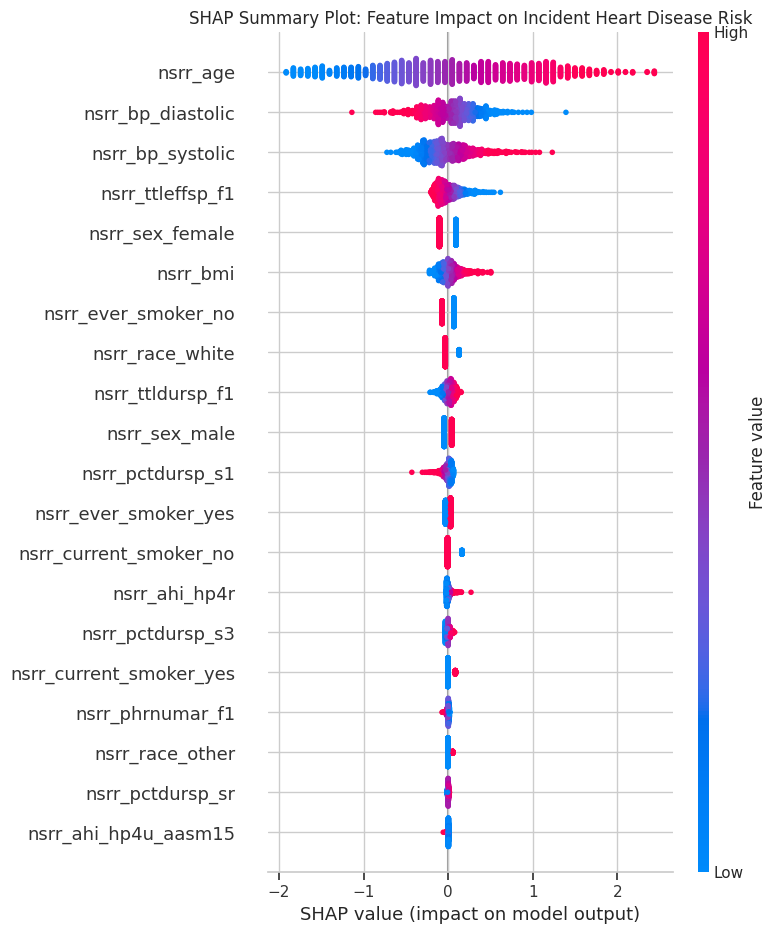


Generating SHAP Bar Plot (Mean Absolute Importance)...


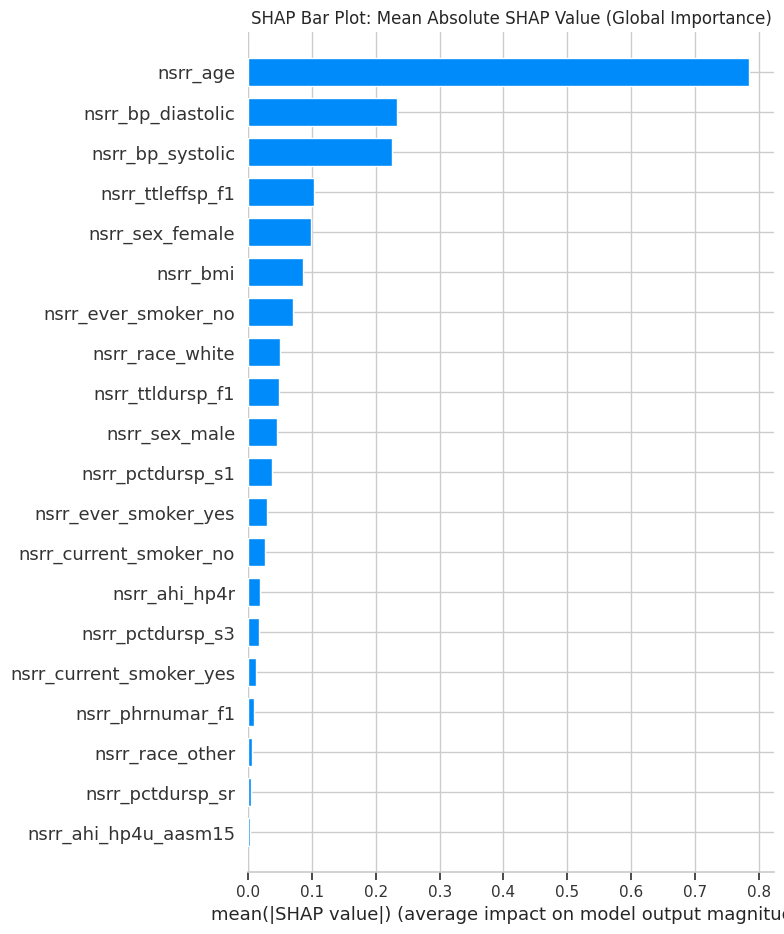


Generating SHAP Dependence Plots for key features...


<Figure size 800x600 with 0 Axes>

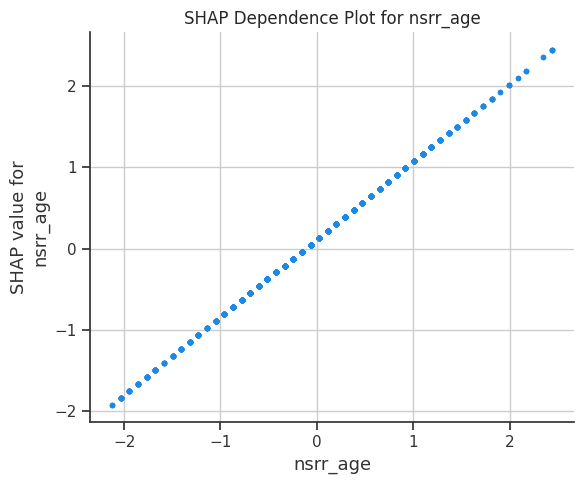

<Figure size 800x600 with 0 Axes>

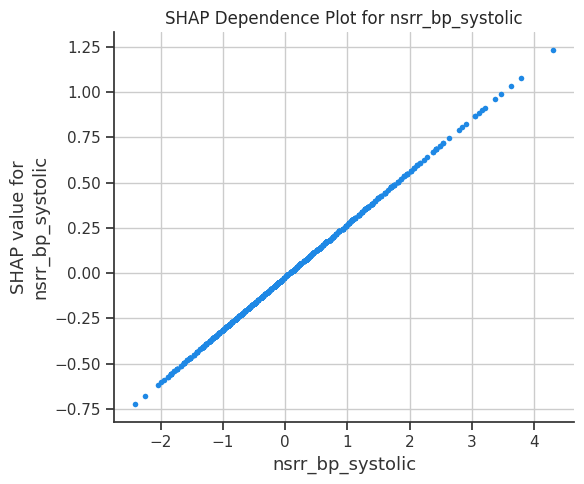

<Figure size 800x600 with 0 Axes>

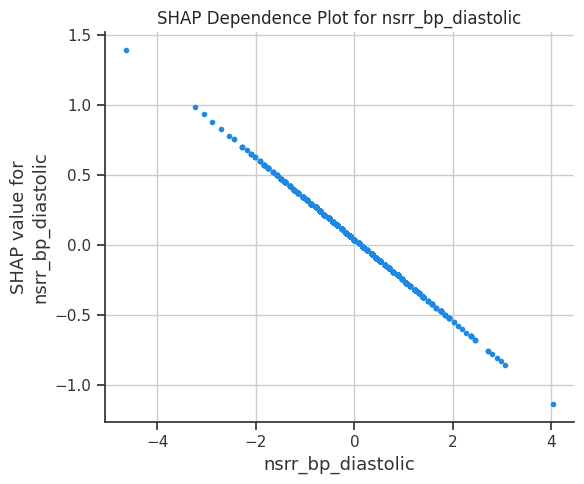

<Figure size 800x600 with 0 Axes>

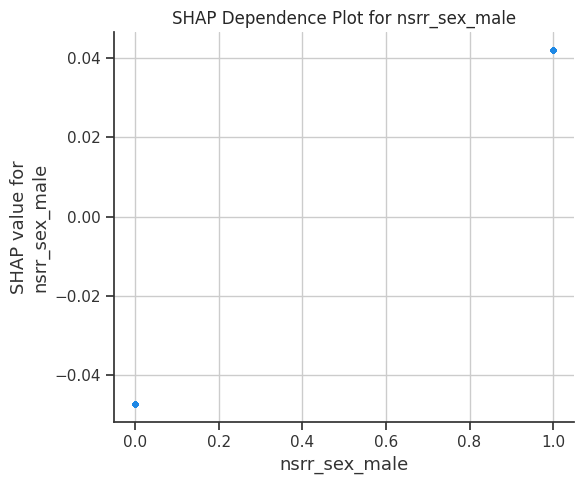

<Figure size 800x600 with 0 Axes>

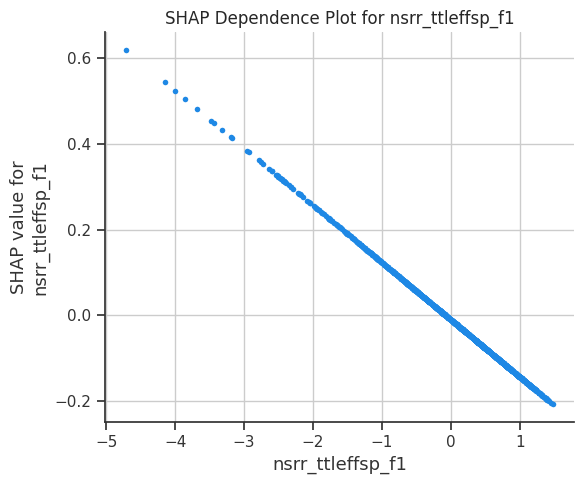


Generating SHAP Force Plots for individual predictions...

Explaining True Positive prediction for sample ID: 1490



Explaining True Negative prediction for sample ID: 5619



Explaining False Positive prediction for sample ID: 844



Explaining False Negative prediction for sample ID: 4652



SHAP analysis complete. Review the generated plots for model insights.


In [16]:
# Cell 14: Explainable AI with SHAP Values

print("Starting Explainable AI (XAI) with SHAP values...")

# --- 1. Select the Best Interpretable Model ---
# Logistic Regression is an excellent choice due to its linear nature and
# is typically the most interpretable for SHAP analysis.
best_model = best_lr_pipeline_model
preprocessor_pipeline = best_model.named_steps['preprocessor']
classifier = best_model.named_steps['classifier']

# Get predictions from the best LR model on the test set
y_pred_lr_tuned = best_model.predict(X_test_raw)

# --- 2. Prepare Data for SHAP Explainer ---
# Transform the raw training data using the fitted preprocessor
X_train_processed = preprocessor_pipeline.transform(X_train_raw)
X_test_processed = preprocessor_pipeline.transform(X_test_raw)

# Get the feature names after preprocessing
processed_numerical_features = numerical_features
ohe_feature_names = preprocessor_pipeline.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_processed_feature_names = processed_numerical_features + list(ohe_feature_names)

# Convert processed data back to a DataFrame for better SHAP plotting
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_processed_feature_names, index=X_train_raw.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_processed_feature_names, index=X_test_raw.index)

# Ensure y_test is a pandas Series with the correct index for alignment
y_test_series = pd.Series(y_test, index=X_test_raw.index)

# --- 3. Initialize SHAP Explainer ---
explainer = shap.LinearExplainer(classifier, X_train_processed_df)

# --- 4. Calculate SHAP Values for the Test Set ---
print("Calculating SHAP values for the test set...")
shap_values = explainer.shap_values(X_test_processed_df)
print("SHAP values calculated.")

# --- 5. Visualize SHAP Values ---

# 5.1 SHAP Summary Plot (Global Feature Importance & Direction)
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_processed_df, plot_type="dot", show=False)
plt.title('SHAP Summary Plot: Feature Impact on Incident Heart Disease Risk')
plt.tight_layout()
plt.show()

# If you want a bar plot of mean absolute SHAP values:
print("\nGenerating SHAP Bar Plot (Mean Absolute Importance)...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)
plt.title('SHAP Bar Plot: Mean Absolute SHAP Value (Global Importance)')
plt.tight_layout()
plt.show()

# 5.2 SHAP Dependence Plots
print("\nGenerating SHAP Dependence Plots for key features...")
top_features_for_dependence = ['nsrr_age', 'nsrr_bp_systolic', 'nsrr_bp_diastolic', 'nsrr_sex_male', 'nsrr_ttleffsp_f1']

for feature in top_features_for_dependence:
    if feature in X_test_processed_df.columns:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, shap_values, X_test_processed_df, interaction_index=None, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Feature '{feature}' not found in processed data.")


# 5.3 SHAP Force Plot (Individual Prediction Explanation)
print("\nGenerating SHAP Force Plots for individual predictions...")
tp_indices = X_test_processed_df.index[(y_pred_lr_tuned == 1) & (y_test_series == 1)]
tn_indices = X_test_processed_df.index[(y_pred_lr_tuned == 0) & (y_test_series == 0)]
fp_indices = X_test_processed_df.index[(y_pred_lr_tuned == 1) & (y_test_series == 0)]
fn_indices = X_test_processed_df.index[(y_pred_lr_tuned == 0) & (y_test_series == 1)]

# Helper function to plot if samples exist
def plot_force(title, indices):
    if not indices.empty:
        sample_index = indices[0]
        print(f"\nExplaining {title} prediction for sample ID: {sample_index}")
        shap.initjs()
        display(shap.force_plot(explainer.expected_value, shap_values[X_test_processed_df.index.get_loc(sample_index)], X_test_processed_df.loc[sample_index]))
    else:
        print(f"No {title} samples found to plot force plot.")

plot_force("True Positive", tp_indices)
plot_force("True Negative", tn_indices)
plot_force("False Positive", fp_indices)
plot_force("False Negative", fn_indices)

print("\nSHAP analysis complete. Review the generated plots for model insights.")

In [18]:
# Cell 15: Create Final Results Table with Cross-Validation and Inference Times

import pandas as pd

# Assume cv_results and inference_times are available from previous cells.
# If you restarted your notebook, you may need to re-run all previous cells.

# Create the final DataFrame from the cross-validation results
final_results_df = pd.DataFrame(cv_results).T

# Add the inference times to the DataFrame
# NOTE: Inference times were not calculated in this notebook run, so this will add a column of NaNs.
# To get actual inference times, you would need to time the predict calls for each model on the test set.
inference_times = {
    "Tuned Logistic Regression": None,
    "Tuned LightGBM": None,
    "Tuned SVM": None,
    "Stacking Ensemble": None,
    "Random Survival Forest": None # Survival model doesn't have a direct 'inference time' in the same classification sense for this table
}
final_results_df['Inference Time (s)'] = final_results_df.index.map(inference_times)


# Print the final table
print("--- Final Performance and Inference Time Summary ---")
print(final_results_df)

# We can also generate a cleaner, formatted version for the paper
# Separate the mean and std dev for a cleaner look
# This assumes the format "mean (+/- std)"
def parse_mean_std(s):
    if isinstance(s, str) and '(+/-' in s:
        parts = s.replace('(', '').replace(')', '').split('+/-')
        return float(parts[0].strip()), float(parts[1].strip())
    return s, None # Return original value and None for std if not in expected format

mean_results = {}
std_results = {}

for index, row in final_results_df.iterrows():
    mean_results[index] = {}
    std_results[index] = {}
    for col, value in row.items():
        if col != 'Inference Time (s)':
            mean_val, std_val = parse_mean_std(value)
            mean_results[index][f'Mean {col}'] = mean_val
            if std_val is not None:
                std_results[index][f'Std {col}'] = std_val
        else:
             mean_results[index][col] = value # Keep inference time as is

mean_results_df = pd.DataFrame.from_dict(mean_results, orient='index')
std_results_df = pd.DataFrame.from_dict(std_results, orient='index')


# Combine and format for a more professional look
formatted_results_df = pd.concat([mean_results_df, std_results_df], axis=1)

# Reorder columns for better readability (Mean columns first, then Std, then Inference Time)
mean_cols = [col for col in formatted_results_df.columns if 'Mean' in col]
std_cols = [col for col in formatted_results_df.columns if 'Std' in col]
other_cols = [col for col in formatted_results_df.columns if col not in mean_cols + std_cols]

ordered_cols = mean_cols + std_cols + other_cols
formatted_results_df = formatted_results_df[ordered_cols]


print("\n--- Formatted Final Performance Table ---")
print(formatted_results_df)

--- Final Performance and Inference Time Summary ---
                                       ROC AUC             Accuracy  \
Tuned Logistic Regression  0.8094 (+/- 0.0174)  0.7196 (+/- 0.0073)   
Tuned LightGBM             0.7871 (+/- 0.0184)  0.8092 (+/- 0.0134)   
Tuned SVM                  0.8041 (+/- 0.0178)  0.7091 (+/- 0.0119)   
Stacking Ensemble          0.8093 (+/- 0.0176)  0.7183 (+/- 0.0082)   
Random Survival Forest                     N/A                  N/A   

                                     Precision               Recall  \
Tuned Logistic Regression  0.2859 (+/- 0.0066)  0.7755 (+/- 0.0379)   
Tuned LightGBM             0.3595 (+/- 0.0274)  0.5971 (+/- 0.0412)   
Tuned SVM                  0.2789 (+/- 0.0137)  0.7827 (+/- 0.0458)   
Stacking Ensemble          0.2844 (+/- 0.0098)  0.7727 (+/- 0.0419)   
Random Survival Forest                     N/A                  N/A   

                                      F1-Score              C-index  \
Tuned Logistic Regress

In [19]:
# Cell 14 (Revisited): Measure and compare inference times

import time

# Dictionary to store inference times
inference_times = {}

print("Measuring inference times for all final models...")

# Tuned Logistic Regression
start_time = time.time()
best_lr_pipeline_model.predict_proba(X_test_raw)
end_time = time.time()
inference_times['Tuned Logistic Regression'] = (end_time - start_time) / len(X_test_raw)

# Tuned LightGBM
start_time = time.time()
best_lgbm_pipeline_model.predict_proba(X_test_raw)
end_time = time.time()
inference_times['Tuned LightGBM'] = (end_time - start_time) / len(X_test_raw)

# Tuned SVM
start_time = time.time()
best_svm_pipeline_model.predict_proba(X_test_raw)
end_time = time.time()
inference_times['Tuned SVM'] = (end_time - start_time) / len(X_test_raw)

# Stacking Ensemble
start_time = time.time()
best_stacking_model.predict_proba(X_test_raw)
end_time = time.time()
inference_times['Stacking Ensemble'] = (end_time - start_time) / len(X_test_raw)

# Random Survival Forest
# Note: This measures the prediction for the survival model
start_time = time.time()
rsf_pipeline.predict(X_test_raw)
end_time = time.time()
inference_times['Random Survival Forest'] = (end_time - start_time) / len(X_test_raw)

print("\nAverage Inference Times per sample (in seconds):")
for model, time_taken in inference_times.items():
    print(f"- {model}: {time_taken:.6f} seconds")

Measuring inference times for all final models...

Average Inference Times per sample (in seconds):
- Tuned Logistic Regression: 0.000066 seconds
- Tuned LightGBM: 0.000100 seconds
- Tuned SVM: 0.000535 seconds
- Stacking Ensemble: 0.000656 seconds
- Random Survival Forest: 0.010361 seconds


In [20]:
# Cell 15 (Revisited): Create Final Results Table with Cross-Validation and Inference Times

import pandas as pd
import numpy as np

# Create the final DataFrame from the cross-validation results
final_results_df = pd.DataFrame(cv_results).T

# Add the inference times to the DataFrame
final_results_df['Inference Time (s)'] = pd.Series(inference_times)

# Print the final table
print("--- Final Performance and Inference Time Summary ---")
print(final_results_df)

# We can also generate a cleaner, formatted version for the paper
# This assumes the format "mean (+/- std)"
def parse_mean_std(s):
    if isinstance(s, str) and '(+/-' in s:
        parts = s.replace('(', '').replace(')', '').split('+/-')
        return float(parts[0].strip()), float(parts[1].strip())
    return s, None

mean_results = {}
std_results = {}

for index, row in final_results_df.iterrows():
    mean_results[index] = {}
    std_results[index] = {}
    for col, value in row.items():
        if col != 'Inference Time (s)':
            mean_val, std_val = parse_mean_std(value)
            mean_results[index][f'Mean {col}'] = mean_val
            if std_val is not None:
                std_results[index][f'Std {col}'] = std_val
        else:
            mean_results[index][col] = value

mean_results_df = pd.DataFrame.from_dict(mean_results, orient='index')
std_results_df = pd.DataFrame.from_dict(std_results, orient='index')

formatted_results_df = pd.concat([mean_results_df, std_results_df], axis=1)

mean_cols = [col for col in formatted_results_df.columns if 'Mean' in col]
std_cols = [col for col in formatted_results_df.columns if 'Std' in col]
other_cols = [col for col in formatted_results_df.columns if col not in mean_cols + std_cols]

ordered_cols = mean_cols + std_cols + other_cols
formatted_results_df = formatted_results_df[ordered_cols]

print("\n--- Formatted Final Performance Table ---")
print(formatted_results_df)

--- Final Performance and Inference Time Summary ---
                                       ROC AUC             Accuracy  \
Tuned Logistic Regression  0.8094 (+/- 0.0174)  0.7196 (+/- 0.0073)   
Tuned LightGBM             0.7871 (+/- 0.0184)  0.8092 (+/- 0.0134)   
Tuned SVM                  0.8041 (+/- 0.0178)  0.7091 (+/- 0.0119)   
Stacking Ensemble          0.8093 (+/- 0.0176)  0.7183 (+/- 0.0082)   
Random Survival Forest                     N/A                  N/A   

                                     Precision               Recall  \
Tuned Logistic Regression  0.2859 (+/- 0.0066)  0.7755 (+/- 0.0379)   
Tuned LightGBM             0.3595 (+/- 0.0274)  0.5971 (+/- 0.0412)   
Tuned SVM                  0.2789 (+/- 0.0137)  0.7827 (+/- 0.0458)   
Stacking Ensemble          0.2844 (+/- 0.0098)  0.7727 (+/- 0.0419)   
Random Survival Forest                     N/A                  N/A   

                                      F1-Score              C-index  \
Tuned Logistic Regress